In [1]:
import sounddevice as sd
import numpy as np
import scipy
import pyaudio
import matplotlib.pyplot as plt
from transformers import pipeline
from scipy.io.wavfile import write

%matplotlib inline

/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sd.query_devices()

   0 HD-Audio Generic: HDMI 0 (hw:0,3), ALSA (0 in, 8 out)
   1 HD-Audio Generic: ALC257 Analog (hw:1,0), ALSA (2 in, 2 out)
   2 Sandberg 126-20: USB Audio (hw:2,0), ALSA (0 in, 2 out)
   3 Sandberg 126-20: USB Audio (hw:3,0), ALSA (0 in, 2 out)
   4 hdmi, ALSA (0 in, 8 out)
   5 jack, ALSA (2 in, 2 out)
   6 pipewire, ALSA (64 in, 64 out)
   7 pulse, ALSA (32 in, 32 out)
*  8 default, ALSA (32 in, 32 out)
   9 Family 17h (Models 10h-1fh) HD Audio Controller Analog Stereo, JACK Audio Connection Kit (0 in, 0 out)
  10 Sandberg 126-20 Mono, JACK Audio Connection Kit (2 in, 0 out)
  11 Sandberg 126-20 Analog Stereo, JACK Audio Connection Kit (4 in, 4 out)
  12 my-virtualmic Audio/Source/Virtual sink, JACK Audio Connection Kit (2 in, 2 out)
  13 my-combined-sink Audio/Sink sink, JACK Audio Connection Kit (2 in, 2 out)

In [5]:
def plot_all_channels(recording):
    n_channels = recording.shape[1]
    fig, axs = plt.subplots(n_channels, 1, figsize=(20, 10))
    for i in range(n_channels):
        axs[i].plot(recording[:, i])
        axs[i].set_title(f"Channel {i}")

### Test recording all 3 channels

In [4]:
recording = sd.rec(frames=44100*3, device=15, channels=3)
sd.wait()

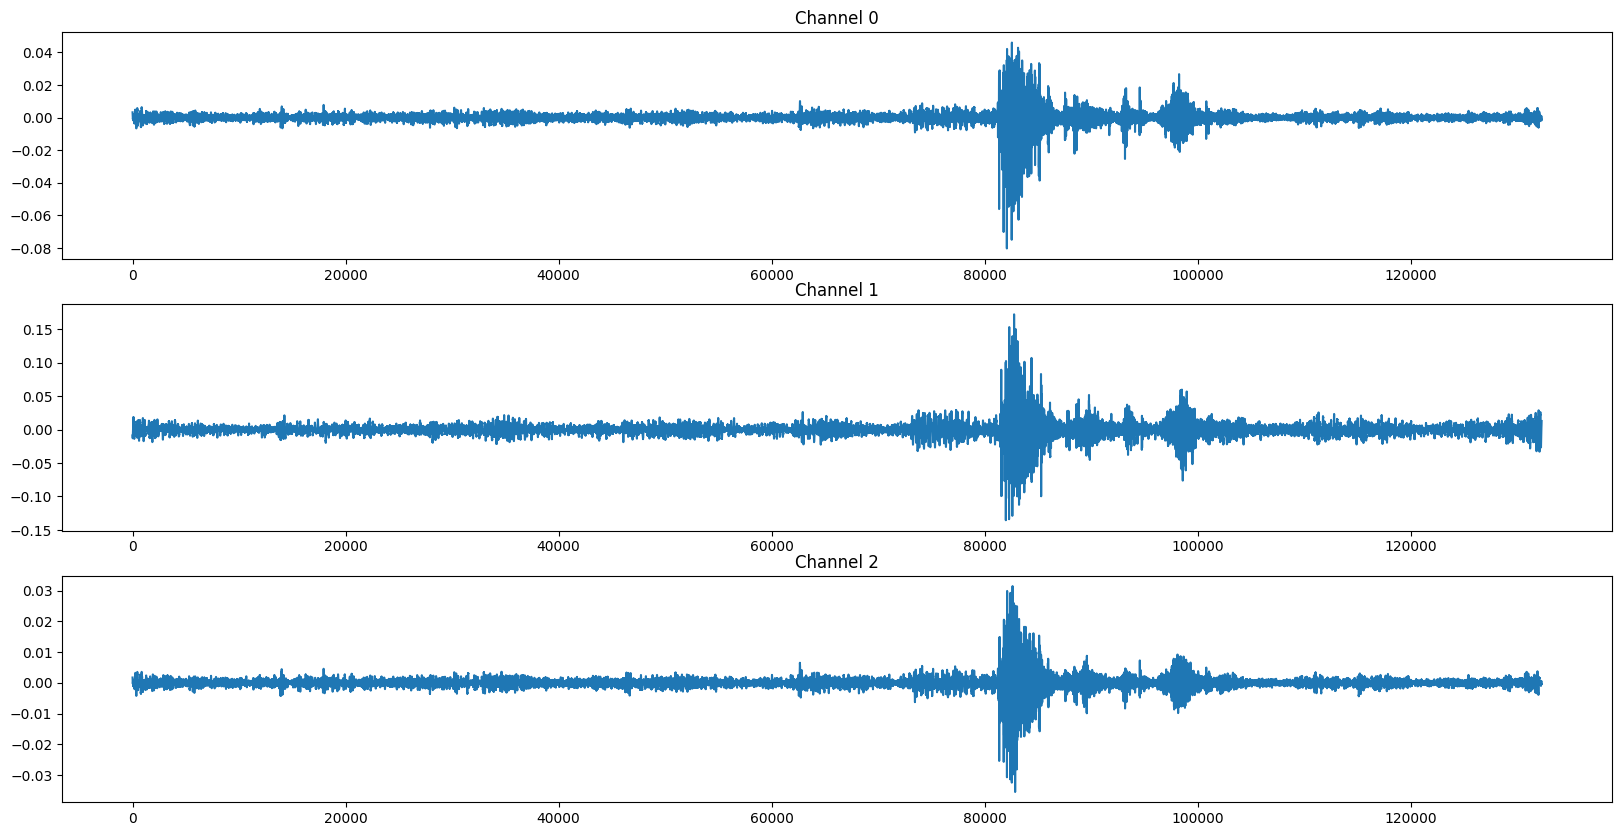

In [6]:
plot_all_channels(recording)
# 0 and 2 are the sandberg 1 is the sennheiser

### Testing DOA

In [15]:
# using sounddevice rec
n_samples = 8000
thresh = 3 #manually tuned depends on the sampling rate !

it = 0
calib = []


while True:
    recording = sd.rec(frames=n_samples, device=13, channels=2, samplerate=16000)
    sd.wait()
    offset = np.argmax(scipy.signal.correlate(recording[:,0], recording[:,1]))-n_samples
    if it < 5:
        calib.append(offset)
        it = it + 1
    else:
        if it == 5:
            zero = np.mean(calib)
            print(f"center offset: {zero}")
            it = it + 1
        if offset < zero-thresh:
            print("gauche")
        elif offset > zero+thresh:
            print("droite")
        else:
            print("indiscernable")

center offset: -4.8
droite
indiscernable
droite
droite
droite
droite
droite
indiscernable
droite
indiscernable
droite
droite
indiscernable
droite
indiscernable
indiscernable
indiscernable
droite
droite
droite
indiscernable
indiscernable
droite
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
droite
indiscernable
indiscernable
droite
indiscernable
gauche
gauche
droite
indiscernable
indiscernable
indiscernable
gauche
gauche
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
gauche
gauche
indiscernable
droite
droite
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
indiscernable
droite
droite
indiscernable
droite
indiscernable
gauche
gauche
gauche
indiscernable
indisce

KeyboardInterrupt: 

### testing KWS

In [10]:
classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-ks")


/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [16]:
while True:
    recording = sd.rec(frames=16000, device=15, channels=3, samplerate=16000)
    sd.wait()
    write('output.wav', 16000, recording[:,1])  # Save as WAV file only the sennhesier
    label = classifier("output.wav", top_k=1)
    if label[0]["score"] > 0.99:
        print(label)
    else:
        print("No keyword detected")
    pass


[{'score': 0.9977627992630005, 'label': '_silence_'}]
No keyword detected
No keyword detected
No keyword detected
No keyword detected
No keyword detected
No keyword detected
No keyword detected
No keyword detected
[{'score': 0.9967852830886841, 'label': 'stop'}]
No keyword detected
No keyword detected
[{'score': 0.9963549375534058, 'label': 'go'}]
No keyword detected
[{'score': 0.9993595480918884, 'label': 'left'}]
No keyword detected
[{'score': 0.9998787641525269, 'label': 'left'}]
No keyword detected
No keyword detected
[{'score': 0.9916219711303711, 'label': 'stop'}]
No keyword detected
[{'score': 0.9962887763977051, 'label': 'stop'}]
No keyword detected
[{'score': 0.9996469020843506, 'label': 'left'}]
No keyword detected
No keyword detected
No keyword detected
[{'score': 0.9996008276939392, 'label': 'left'}]
No keyword detected


KeyboardInterrupt: 

### Both together

In [ ]:
classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-ks")

In [23]:
LINE_CLEAR = '\x1b[2K'
it = 0
n_samples = 8000 # 0.5s
while True:
    recording = sd.rec(frames=n_samples, device=15, channels=3, samplerate=16000)
    sd.wait()
    offset = np.argmax(scipy.signal.correlate(recording[:,0], recording[:,2]))-n_samples
    if it < 5: # calibration for the first 2s 
        if it == 0:
            print("Calibration for DOA be quiet")
        calib.append(offset)
        it = it + 1
    if it == 5:
        print("Calibration done")
        zero = np.mean(calib)
        print(f"center offset: {zero}")
        it = it + 1
    if it > 5:
        ### KWS ###
        write('output.wav', 16000, recording[:,1])  # Save as WAV file only the sennhesier
        label = classifier("output.wav", top_k=1)
        if label[0]["score"] > 0.99:
            keyword = label[0]["label"]
        else:
            keyword = "No keyword detected"
        ### DOA ###
        if offset < zero-thresh:
            doa = "left"
        elif offset > zero+thresh:
            doa = "right"
        else:
            doa = "center or unidentified"
        print(f"Keyword: {keyword} | DOA: {doa}", end=LINE_CLEAR+"\r")

Calibration for DOA be quiet
Calibration done
center offset: 0.875


KeyboardInterrupt: 